# Antisemitism Detection Analysis in Social Media

This interactive notebook analyzes the performance of antisemitism detection models with a specific focus on false positives. It provides comprehensive visualizations and metrics to understand model behavior across different tweet lengths, keywords, and model sizes.

## Project Overview
This analysis examines how language models (LLMs) perform when tasked with detecting antisemitism in social media content. The analysis focuses on:
- Comparing performance across model sizes (7B vs 8B parameter models)
- Evaluating different antisemitism definitions (IHRA vs JDA)
- Understanding false positive patterns by tweet length, keywords, and topics

## Instructions
1. Run all cells in this notebook
2. Results will be saved to your Google Drive
3. Visualizations will be displayed in the notebook
4. A zip file with all results can be downloaded at the end

In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                           precision_score, recall_score, f1_score, fbeta_score,
                           balanced_accuracy_score, matthews_corrcoef)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import os
from collections import defaultdict
from google.colab import drive, files

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [37]:
# Mount Google Drive and set up file paths
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")

    # Set default paths for Google Colab
    base_path = '/content/drive/MyDrive/Antisemitism_Detection_Project/'
    print(f"Files will be saved to: {base_path}")

    # Create these folders in your Google Drive if they don't exist
    input_file_path = base_path + 'comparative_model_results.csv'

    # You can upload the file directly to Colab if not in Drive
    if not os.path.exists(input_file_path):
        print("Input file not found in Drive. You'll be prompted to upload it later.")

except:
    print("Running in local environment, not mounting Google Drive")
    base_path = './'
    input_file_path = 'comparative_model_results.csv'

# Create directory structure for outputs
os.makedirs(os.path.join(base_path, 'plots'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'results'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'plots/fp_analysis'), exist_ok=True)

Running in local environment, not mounting Google Drive


In [38]:
# Function to create output directories
def create_output_dirs(base_path='.'):
    """
    Create directories for outputs

    Args:
        base_path: Base path for output directories

    Returns:
        Dictionary with paths to the directories
    """
    # Create base directories
    os.makedirs(os.path.join(base_path, 'plots'), exist_ok=True)
    os.makedirs(os.path.join(base_path, 'results'), exist_ok=True)
    os.makedirs(os.path.join(base_path, 'plots/fp_analysis'), exist_ok=True)

    return {
        'plots': os.path.join(base_path, 'plots'),
        'results': os.path.join(base_path, 'results'),
        'fp_plots': os.path.join(base_path, 'plots/fp_analysis')
    }

In [39]:
# Function to calculate F-beta score with beta=0.5 (emphasizing precision)
def calculate_fbeta(y_true, y_pred, beta=0.5):
    """
    Calculate F-beta score with beta=0.5 to emphasize precision over recall

    Args:
        y_true: True labels
        y_pred: Predicted labels
        beta: Beta value (default: 0.5)

    Returns:
        F-beta score
    """
    return fbeta_score(y_true, y_pred, beta=beta)

In [40]:
# Function to display focused performance metrics
def display_focused_metrics(true_labels, predicted_labels, model_name):
    """
    Calculate and display focused performance metrics with emphasis on false positives

    Args:
        true_labels: Ground truth labels (0/1 where 1=antisemitic)
        predicted_labels: Model predictions (0/1 where 1=antisemitic)
        model_name: Name of the model/definition

    Returns:
        Dictionary of metrics
    """
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

    # Core metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)

    # Focus metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 1 - false positive rate
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    f05 = calculate_fbeta(true_labels, predicted_labels, beta=0.5)

    # False positive rate
    fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0

    # Additional metrics
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

    # Total number of predicted positives
    predicted_positives = tp + fp

    print(f"\n===== Performance Metrics for {model_name} =====")
    print(f"Precision:          {precision:.4f} - Of tweets classified as antisemitic, {precision * 100:.1f}% were actually antisemitic")
    print(f"Specificity:        {specificity:.4f} - Correctly identified {specificity * 100:.1f}% of non-antisemitic tweets")
    print(f"False Positive Rate: {fp_rate:.4f} - Incorrectly classified {fp_rate * 100:.1f}% of non-antisemitic tweets as antisemitic")
    print(f"F0.5 Score:         {f05:.4f} - Weighted harmonic mean of precision and recall (precision weighted more)")
    print(f"F1 Score:           {f1:.4f} - Balanced harmonic mean of precision and recall")
    print(f"Recall/Sensitivity: {recall:.4f} - Found {recall * 100:.1f}% of all antisemitic tweets")
    print(f"Balanced Accuracy:  {balanced_acc:.4f}")
    print(f"Matthews Corr Coef: {mcc:.4f}")

    print("\nError Analysis:")
    print(f"False Positives:    {fp} tweets ({fp / predicted_positives * 100:.1f}% of all antisemitic predictions)")
    print(f"False Negatives:    {fn} tweets")
    print(f"Total Errors:       {fp + fn} tweets")

    # Return metrics dictionary
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'f05': f05,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'false_positive_rate': fp_rate,
        'true_positive': tp,
        'false_positive': fp,
        'true_negative': tn,
        'false_negative': fn,
        'total_predicted_positive': predicted_positives
    }

In [41]:
# Function to analyze false positives by tweet length
def analyze_fp_by_length(df, model_col, dirs):
    """
    Analyze false positives by tweet length

    Args:
        df: DataFrame containing model results
        model_col: Column name for model predictions
        dirs: Dictionary with output directories

    Returns:
        DataFrame with false positive rates by length bin
    """
    # Create length bins
    bins = [0, 80, 120, 160, 200, 240, 280, 320, 400, 600, 1000]
    labels = ['0-80', '81-120', '121-160', '161-200', '201-240',
              '241-280', '281-320', '321-400', '401-600', '601+']

    df['length_bin'] = pd.cut(df['text_length'], bins=bins, labels=labels)

    # Calculate false positive metrics by length bin
    length_stats = []

    for length_bin in labels:
        bin_df = df[df['length_bin'] == length_bin]
        if len(bin_df) == 0:
            continue

        # Filter non-antisemitic tweets (ground truth = 0)
        non_antisemitic = bin_df[bin_df['Biased'] == 0]
        if len(non_antisemitic) == 0:
            continue

        # Count false positives
        fp = non_antisemitic[non_antisemitic[model_col] == 1]

        # Calculate metrics
        fp_rate = len(fp) / len(non_antisemitic)

        length_stats.append({
            'Length_Bin': length_bin,
            'Tweet_Count': len(bin_df),
            'Non_Antisemitic_Count': len(non_antisemitic),
            'False_Positive_Count': len(fp),
            'False_Positive_Rate': fp_rate
        })

    # Create DataFrame
    length_df = pd.DataFrame(length_stats)

    # Plot false positive rate by length
    plt.figure(figsize=(12, 6))
    bars = plt.bar(length_df['Length_Bin'], length_df['False_Positive_Rate'], color='indianred')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('False Positive Rate')
    model_name = model_col.replace('_Binary', '')
    plt.title(f'False Positive Rate by Tweet Length - {model_name}')
    plt.ylim(0, min(1.0, length_df['False_Positive_Rate'].max() * 1.2))
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add count labels
    for i, row in length_df.iterrows():
        plt.text(i, row['False_Positive_Rate'] + 0.01,
                 f"{row['False_Positive_Count']}/{row['Non_Antisemitic_Count']}",
                 ha='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(dirs['fp_plots'], f'fp_by_length_{model_name}.png'))
    # Display in notebook
    plt.show()

    return length_df

In [42]:
# Function to analyze false positives by keyword
def analyze_fp_by_keyword(df, model_col, dirs, top_n=15):
    """
    Analyze false positives by keyword

    Args:
        df: DataFrame containing model results
        model_col: Column name for model predictions
        dirs: Dictionary with output directories
        top_n: Number of top keywords to include in plot

    Returns:
        DataFrame with false positive rates by keyword
    """
    # Calculate false positive metrics by keyword
    keyword_stats = []

    for keyword in df['Keyword'].unique():
        keyword_df = df[df['Keyword'] == keyword]
        if len(keyword_df) < 5:  # Skip keywords with too few examples
            continue

        # Filter non-antisemitic tweets (ground truth = 0)
        non_antisemitic = keyword_df[keyword_df['Biased'] == 0]
        if len(non_antisemitic) == 0:
            continue

        # Count false positives
        fp = non_antisemitic[non_antisemitic[model_col] == 1]

        # Calculate metrics
        fp_rate = len(fp) / len(non_antisemitic)

        keyword_stats.append({
            'Keyword': keyword,
            'Tweet_Count': len(keyword_df),
            'Non_Antisemitic_Count': len(non_antisemitic),
            'False_Positive_Count': len(fp),
            'False_Positive_Rate': fp_rate
        })

    # Create DataFrame and sort by false positive rate
    keyword_df = pd.DataFrame(keyword_stats)
    keyword_df = keyword_df.sort_values('False_Positive_Rate', ascending=False)

    # Select top N keywords with most false positives
    top_keywords = keyword_df.head(top_n)

    # Plot false positive rate by keyword
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_keywords['Keyword'], top_keywords['False_Positive_Rate'], color='darkorange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Keyword')
    model_name = model_col.replace('_Binary', '')
    plt.title(f'False Positive Rate by Keyword - {model_name}')
    plt.xlim(0, min(1.0, top_keywords['False_Positive_Rate'].max() * 1.2))
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add count labels
    for bar, (i, row) in zip(bars, top_keywords.iterrows()):
        plt.text(row['False_Positive_Rate'] + 0.01, bar.get_y() + bar.get_height() / 2,
                 f"{row['False_Positive_Count']}/{row['Non_Antisemitic_Count']}",
                 va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(dirs['fp_plots'], f'fp_by_keyword_{model_name}.png'))
    # Display in notebook
    plt.show()

    return keyword_df

In [43]:
# Function to perform topic modeling on false positives
def analyze_fp_topics(df, model_col, n_topics=5, dirs=None):
    """
    Perform topic modeling on false positive tweets

    Args:
        df: DataFrame containing model results
        model_col: Column name for model predictions
        n_topics: Number of topics to identify
        dirs: Dictionary with output directories

    Returns:
        Dictionary with topic modeling results
    """
    # Identify false positives
    false_positives = df[(df['Biased'] == 0) & (df[model_col] == 1)]

    if len(false_positives) < 10:
        print(f"Too few false positives for topic modeling: {len(false_positives)}")
        return None

    # Preprocess text
    texts = false_positives['Text'].tolist()

    # Create document-term matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Perform LDA topic modeling
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Extract top words per topic
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append({
            'topic_id': topic_idx,
            'words': top_words,
            'weights': topic[top_words_idx].tolist()
        })

    # Assign topics to false positives
    topic_assignments = lda.transform(dtm)
    false_positives['Topic'] = topic_assignments.argmax(axis=1)

    # Count tweets per topic
    topic_counts = false_positives['Topic'].value_counts().to_dict()

    # Store topic info
    for i, topic in enumerate(topics):
        topic['tweet_count'] = topic_counts.get(i, 0)
        topic['percentage'] = topic['tweet_count'] / len(false_positives)

    # Plot topic distribution
    if dirs:
        # Plot topic distribution
        topic_df = pd.DataFrame({
            'Topic': [f"Topic {i+1}: {' '.join(topic['words'][:3])}" for i, topic in enumerate(topics)],
            'Count': [topic['tweet_count'] for topic in topics]
        })

        # Sort by count
        topic_df = topic_df.sort_values('Count', ascending=False)

        plt.figure(figsize=(14, 8))
        bars = plt.barh(topic_df['Topic'], topic_df['Count'], color='mediumseagreen')
        plt.xlabel('Number of False Positive Tweets')
        plt.ylabel('Topic')
        model_name = model_col.replace('_Binary', '')
        plt.title(f'False Positive Topics - {model_name}')
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add percentage labels
        for bar, (i, row) in zip(bars, topic_df.iterrows()):
            percentage = row['Count'] / topic_df['Count'].sum() * 100
            plt.text(row['Count'] + 1, bar.get_y() + bar.get_height() / 2,
                    f"{percentage:.1f}%", va='center')

        plt.tight_layout()
        plt.savefig(os.path.join(dirs['fp_plots'], f'fp_topics_{model_name}.png'))
        # Display in notebook
        plt.show()

        # Create a more detailed HTML output with examples (save to Google Drive)
        samples_per_topic = defaultdict(list)
        for _, row in false_positives.iterrows():
            if len(samples_per_topic[row['Topic']]) < 5:  # Get 5 examples per topic
                samples_per_topic[row['Topic']].append(row['Text'])

        html_content = f"<h1>False Positive Analysis for {model_name}</h1>\n"
        html_content += "<p>Topics identified in false positive tweets</p>\n"

        for i, topic in enumerate(topics):
            html_content += f"<h2>Topic {i+1} ({topic['tweet_count']} tweets, {topic['percentage']*100:.1f}%)</h2>\n"
            html_content += "<h3>Top words:</h3>\n<ul>\n"
            for word, weight in zip(topic['words'], topic['weights']):
                html_content += f"<li>{word} ({weight:.3f})</li>\n"
            html_content += "</ul>\n"

            html_content += "<h3>Example tweets:</h3>\n<ul>\n"
            for sample in samples_per_topic.get(i, []):
                html_content += f"<li>{sample}</li>\n"
            html_content += "</ul>\n"

        with open(os.path.join(dirs['results'], f'fp_topic_analysis_{model_name}.html'), 'w', encoding='utf-8') as f:
            f.write(html_content)

    return {
        'topics': topics,
        'topic_assignments': topic_assignments,
        'false_positives': false_positives
    }

In [44]:
# Function to compare false positives between model sizes
def compare_model_sizes(df, dirs):
    """
    Compare false positive patterns between model sizes

    Args:
        df: DataFrame containing results from both model sizes
        dirs: Dictionary with output directories

    Returns:
        Dictionary with comparison results
    """
    # Extract metrics for different model sizes
    metrics_7b_ihra = display_focused_metrics(df['Biased'], df['IHRA_Binary_7B'], "IHRA Definition (7B)")
    metrics_8b_ihra = display_focused_metrics(df['Biased'], df['IHRA_Binary_8B'], "IHRA Definition (8B)")
    metrics_7b_jda = display_focused_metrics(df['Biased'], df['JDA_Binary_7B'], "JDA Definition (7B)")
    metrics_8b_jda = display_focused_metrics(df['Biased'], df['JDA_Binary_8B'], "JDA Definition (8B)")

    # Compile metrics for comparison
    metrics = [metrics_7b_ihra, metrics_8b_ihra, metrics_7b_jda, metrics_8b_jda]

    # Create model size comparison table
    comparison_data = {
        'Metric': ['Precision', 'Specificity', 'False Positive Rate', 'F0.5 Score', 'F1 Score', 'Recall'],
        'IHRA 7B': [metrics_7b_ihra['precision'], metrics_7b_ihra['specificity'],
                  metrics_7b_ihra['false_positive_rate'], metrics_7b_ihra['f05'],
                  metrics_7b_ihra['f1'], metrics_7b_ihra['recall']],
        'IHRA 8B': [metrics_8b_ihra['precision'], metrics_8b_ihra['specificity'],
                  metrics_8b_ihra['false_positive_rate'], metrics_8b_ihra['f05'],
                  metrics_8b_ihra['f1'], metrics_8b_ihra['recall']],
        'JDA 7B': [metrics_7b_jda['precision'], metrics_7b_jda['specificity'],
                 metrics_7b_jda['false_positive_rate'], metrics_7b_jda['f05'],
                 metrics_7b_jda['f1'], metrics_7b_jda['recall']],
        'JDA 8B': [metrics_8b_jda['precision'], metrics_8b_jda['specificity'],
                 metrics_8b_jda['false_positive_rate'], metrics_8b_jda['f05'],
                 metrics_8b_jda['f1'], metrics_8b_jda['recall']]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print("\n===== Model Size Comparison =====")
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(comparison_df)

    # Save comparison to CSV
    comparison_df.to_csv(os.path.join(dirs['results'], 'model_size_comparison.csv'), index=False)

    # Calculate relative improvements from 7B to 8B
    improvement_data = {
        'Metric': ['Precision', 'Specificity', 'False Positive Rate', 'F0.5 Score', 'F1 Score', 'Recall'],
        'IHRA Improvement': [
            (metrics_8b_ihra['precision'] - metrics_7b_ihra['precision']) / max(0.0001, metrics_7b_ihra['precision']),
            (metrics_8b_ihra['specificity'] - metrics_7b_ihra['specificity']) / max(0.0001, metrics_7b_ihra['specificity']),
            (metrics_7b_ihra['false_positive_rate'] - metrics_8b_ihra['false_positive_rate']) / max(0.0001, metrics_7b_ihra['false_positive_rate']),
            (metrics_8b_ihra['f05'] - metrics_7b_ihra['f05']) / max(0.0001, metrics_7b_ihra['f05']),
            (metrics_8b_ihra['f1'] - metrics_7b_ihra['f1']) / max(0.0001, metrics_7b_ihra['f1']),
            (metrics_8b_ihra['recall'] - metrics_7b_ihra['recall']) / max(0.0001, metrics_7b_ihra['recall'])
        ],
        'JDA Improvement': [
            (metrics_8b_jda['precision'] - metrics_7b_jda['precision']) / max(0.0001, metrics_7b_jda['precision']),
            (metrics_8b_jda['specificity'] - metrics_7b_jda['specificity']) / max(0.0001, metrics_7b_jda['specificity']),
            (metrics_7b_jda['false_positive_rate'] - metrics_8b_jda['false_positive_rate']) / max(0.0001, metrics_7b_jda['false_positive_rate']),
            (metrics_8b_jda['f05'] - metrics_7b_jda['f05']) / max(0.0001, metrics_7b_jda['f05']),
            (metrics_8b_jda['f1'] - metrics_7b_jda['f1']) / max(0.0001, metrics_7b_jda['f1']),
            (metrics_8b_jda['recall'] - metrics_7b_jda['recall']) / max(0.0001, metrics_7b_jda['recall'])
        ]
    }

    improvement_df = pd.DataFrame(improvement_data)
    pd.set_option('display.float_format', '{:.2%}'.format)
    print("\n===== Relative Improvement (7B to 8B) =====")
    print(improvement_df)

    # Save improvement to CSV
    improvement_df.to_csv(os.path.join(dirs['results'], 'model_size_improvement.csv'), index=False)

    # Create comparison visualizations
    # Focus metrics comparison
    plt.figure(figsize=(14, 8))

    metrics_to_plot = ['Precision', 'Specificity', 'F0.5 Score', 'F1 Score', 'Recall']
    x = np.arange(len(metrics_to_plot))
    width = 0.2

    plt.bar(x - width*1.5, [metrics_7b_ihra[m.lower()] for m in ['precision', 'specificity', 'f05', 'f1', 'recall']],
            width, label='IHRA 7B', color='royalblue')
    plt.bar(x - width*0.5, [metrics_8b_ihra[m.lower()] for m in ['precision', 'specificity', 'f05', 'f1', 'recall']],
            width, label='IHRA 8B', color='lightsteelblue')
    plt.bar(x + width*0.5, [metrics_7b_jda[m.lower()] for m in ['precision', 'specificity', 'f05', 'f1', 'recall']],
            width, label='JDA 7B', color='darkgreen')
    plt.bar(x + width*1.5, [metrics_8b_jda[m.lower()] for m in ['precision', 'specificity', 'f05', 'f1', 'recall']],
            width, label='JDA 8B', color='lightgreen')

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Performance Comparison Between Model Sizes')
    plt.xticks(x, metrics_to_plot)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], 'model_size_performance_comparison.png'))
    # Display in notebook
    plt.show()

    # False positive rate comparison
    plt.figure(figsize=(10, 6))

    plt.bar(['IHRA 7B', 'IHRA 8B', 'JDA 7B', 'JDA 8B'],
            [metrics_7b_ihra['false_positive_rate'], metrics_8b_ihra['false_positive_rate'],
             metrics_7b_jda['false_positive_rate'], metrics_8b_jda['false_positive_rate']],
            color=['royalblue', 'lightsteelblue', 'darkgreen', 'lightgreen'])

    plt.xlabel('Model')
    plt.ylabel('False Positive Rate')
    plt.title('False Positive Rate Comparison Between Model Sizes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels
    for i, v in enumerate([metrics_7b_ihra['false_positive_rate'], metrics_8b_ihra['false_positive_rate'],
                           metrics_7b_jda['false_positive_rate'], metrics_8b_jda['false_positive_rate']]):
        plt.text(i, v + 0.01, f"{v:.2%}", ha='center')

    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], 'model_size_fp_rate_comparison.png'))
    # Display in notebook
    plt.show()

    # Calculate difference in false positive classification between model sizes
    df['IHRA_FP_7B'] = ((df['Biased'] == 0) & (df['IHRA_Binary_7B'] == 1)).astype(int)
    df['IHRA_FP_8B'] = ((df['Biased'] == 0) & (df['IHRA_Binary_8B'] == 1)).astype(int)
    df['JDA_FP_7B'] = ((df['Biased'] == 0) & (df['JDA_Binary_7B'] == 1)).astype(int)
    df['JDA_FP_8B'] = ((df['Biased'] == 0) & (df['JDA_Binary_8B'] == 1)).astype(int)

    # Compare false positives: fixed in 8B vs introduced in 8B
    ihra_fixed = ((df['IHRA_FP_7B'] == 1) & (df['IHRA_FP_8B'] == 0)).sum()
    ihra_introduced = ((df['IHRA_FP_7B'] == 0) & (df['IHRA_FP_8B'] == 1)).sum()
    ihra_persistent = ((df['IHRA_FP_7B'] == 1) & (df['IHRA_FP_8B'] == 1)).sum()

    jda_fixed = ((df['JDA_FP_7B'] == 1) & (df['JDA_FP_8B'] == 0)).sum()
    jda_introduced = ((df['JDA_FP_7B'] == 0) & (df['JDA_FP_8B'] == 1)).sum()
    jda_persistent = ((df['JDA_FP_7B'] == 1) & (df['JDA_FP_8B'] == 1)).sum()

    fp_change_data = {
        'Category': ['Fixed in 8B', 'Introduced in 8B', 'Persistent'],
        'IHRA Count': [ihra_fixed, ihra_introduced, ihra_persistent],
        'JDA Count': [jda_fixed, jda_introduced, jda_persistent]
    }

    fp_change_df = pd.DataFrame(fp_change_data)
    print("\n===== False Positive Changes from 7B to 8B =====")
    print(fp_change_df)

    # Save FP change data
    fp_change_df.to_csv(os.path.join(dirs['results'], 'fp_changes_by_model_size.csv'), index=False)

    # Plot FP changes
    plt.figure(figsize=(10, 6))

    x = np.arange(len(fp_change_df['Category']))
    width = 0.35

    plt.bar(x - width/2, fp_change_df['IHRA Count'], width, label='IHRA', color='royalblue')
    plt.bar(x + width/2, fp_change_df['JDA Count'], width, label='JDA', color='darkgreen')

    plt.xlabel('Category')
    plt.ylabel('Number of False Positives')
    plt.title('False Positive Changes from 7B to 8B Model')
    plt.xticks(x, fp_change_df['Category'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add count labels
    for i, v in enumerate(fp_change_df['IHRA Count']):
        plt.text(i - width/2, v + 5, str(v), ha='center')

    for i, v in enumerate(fp_change_df['JDA Count']):
        plt.text(i + width/2, v + 5, str(v), ha='center')

    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], 'fp_changes_by_model_size.png'))
    # Display in notebook
    plt.show()

    return {
        'comparison': comparison_df,
        'improvement': improvement_df,
        'fp_changes': fp_change_df,
        'metrics': metrics
    }

In [45]:
# Function to show dataset statistics and distributions
def show_dataset_stats(df):
    """
    Display basic statistics and visualizations about the dataset

    Args:
        df: DataFrame containing the dataset
    """
    # Basic statistics
    print("📊 Dataset Overview")
    print(f"Total examples: {len(df):,}")
    print(f"Antisemitic examples: {df['Biased'].sum():,} ({df['Biased'].mean()*100:.1f}%)")
    print(f"Non-antisemitic examples: {(df['Biased'] == 0).sum():,} ({(1-df['Biased'].mean())*100:.1f}%)")

    # Sample distribution by keywords
    keyword_counts = df['Keyword'].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Plot keywords distribution
    top_keywords = keyword_counts.head(15)
    colors = sns.color_palette("viridis", len(top_keywords))
    bars = ax1.bar(top_keywords.index, top_keywords.values, color=colors)
    ax1.set_xlabel('Keyword')
    ax1.set_ylabel('Count')
    ax1.set_title('Keywords in Dataset')
    ax1.set_xticklabels(top_keywords.index, rotation=45, ha='right')

    # Add count labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height+5,
                f'{height:,}', ha='center', va='bottom')

    # Distribution of text lengths
    ax2.hist(df['text_length'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Text Length (characters)')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Text Lengths')

    # Add mean and median lines
    mean_length = df['text_length'].mean()
    median_length = df['text_length'].median()

    ax2.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.1f}')
    ax2.axvline(median_length, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_length:.1f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Additional analysis - Label distribution by keyword
    plt.figure(figsize=(14, 8))

    # Group by keyword and calculate percentage of antisemitic tweets
    keyword_bias = df.groupby('Keyword')['Biased'].agg(['count', 'mean'])
    keyword_bias = keyword_bias.sort_values('mean', ascending=False)
    keyword_bias = keyword_bias[keyword_bias['count'] >= 10]  # Only include keywords with at least 10 examples

    # Create a stacked bar chart
    plt.figure(figsize=(14, 8))
    bars = plt.barh(keyword_bias.index[:15], keyword_bias['mean'][:15]*100, color='crimson')
    plt.xlabel('Percentage of Antisemitic Tweets')
    plt.ylabel('Keyword')
    plt.title('Keywords by Antisemitism Percentage')
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add percentage and count labels
    for i, (idx, row) in enumerate(keyword_bias[:15].iterrows()):
        plt.text(row['mean']*100 + 2, i,
                 f"{row['mean']*100:.1f}% ({row['count']:,} tweets)",
                 va='center')

    plt.tight_layout()
    plt.show()

## Main Analysis Functions

Below are the main analysis functions that will process the data and generate visualizations.

In [46]:
# Main analysis function
def analyze_antisemitism_detection(input_file=input_file_path, fp_analysis=True, n_topics=5, output_base_path=base_path):
    """
    Main function to run the complete analysis pipeline

    Args:
        input_file: Path to the CSV file with model results
        fp_analysis: Whether to perform detailed false positive analysis with topic modeling
        n_topics: Number of topics for topic modeling
        output_base_path: Base path for output files

    Returns:
        Summary of the analysis results
    """
    print("🔍 Starting Antisemitism Detection Analysis...")

    # Create output directories
    dirs = create_output_dirs(output_base_path)

    # Load the dataset
    try:
        df = pd.read_csv(input_file)
        print(f"✅ Loaded dataset from {input_file} with {len(df):,} entries")
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        print("Please upload the comparative_model_results.csv file")
        uploaded = files.upload()
        df = pd.read_csv(list(uploaded.keys())[0])
        print(f"✅ Loaded uploaded dataset with {len(df):,} entries")

    # Show dataset overview
    print("\n📊 Dataset Statistics and Distributions")
    show_dataset_stats(df)

    # Compare model sizes
    print("\n📈 Comparing Model Sizes and Definitions")
    comparison_results = compare_model_sizes(df, dirs)

    print("\n📏 Analyzing False Positives by Tweet Length")
    # Analyze false positives by tweet length for all model variants
    fp_length_ihra_7b = analyze_fp_by_length(df, 'IHRA_Binary_7B', dirs)
    fp_length_ihra_8b = analyze_fp_by_length(df, 'IHRA_Binary_8B', dirs)
    fp_length_jda_7b = analyze_fp_by_length(df, 'JDA_Binary_7B', dirs)
    fp_length_jda_8b = analyze_fp_by_length(df, 'JDA_Binary_8B', dirs)

    # Save false positive by length analysis
    fp_length_results = pd.concat([
        fp_length_ihra_7b.assign(Model='IHRA_7B'),
        fp_length_ihra_8b.assign(Model='IHRA_8B'),
        fp_length_jda_7b.assign(Model='JDA_7B'),
        fp_length_jda_8b.assign(Model='JDA_8B')
    ])
    fp_length_results.to_csv(os.path.join(dirs['results'], 'fp_by_length_analysis.csv'), index=False)

    # Create comparative length visualization
    plt.figure(figsize=(14, 8))

    plt.plot(fp_length_ihra_7b['Length_Bin'], fp_length_ihra_7b['False_Positive_Rate'],
             marker='o', label='IHRA 7B', color='royalblue', linewidth=2)
    plt.plot(fp_length_ihra_8b['Length_Bin'], fp_length_ihra_8b['False_Positive_Rate'],
             marker='s', label='IHRA 8B', color='lightsteelblue', linestyle='--', linewidth=2)
    plt.plot(fp_length_jda_7b['Length_Bin'], fp_length_jda_7b['False_Positive_Rate'],
             marker='^', label='JDA 7B', color='darkgreen', linewidth=2)
    plt.plot(fp_length_jda_8b['Length_Bin'], fp_length_jda_8b['False_Positive_Rate'],
             marker='d', label='JDA 8B', color='lightgreen', linestyle='--', linewidth=2)

    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('False Positive Rate')
    plt.title('False Positive Rate by Tweet Length - Model Size Comparison')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], 'fp_by_length_model_comparison.png'))
    plt.show()

    print("\n🔑 Analyzing False Positives by Keyword")
    # Analyze false positives by keyword for all model variants
    fp_keyword_ihra_7b = analyze_fp_by_keyword(df, 'IHRA_Binary_7B', dirs)
    fp_keyword_ihra_8b = analyze_fp_by_keyword(df, 'IHRA_Binary_8B', dirs)
    fp_keyword_jda_7b = analyze_fp_by_keyword(df, 'JDA_Binary_7B', dirs)
    fp_keyword_jda_8b = analyze_fp_by_keyword(df, 'JDA_Binary_8B', dirs)

    # Save false positive by keyword analysis
    fp_keyword_results = pd.concat([
        fp_keyword_ihra_7b.assign(Model='IHRA_7B'),
        fp_keyword_ihra_8b.assign(Model='IHRA_8B'),
        fp_keyword_jda_7b.assign(Model='JDA_7B'),
        fp_keyword_jda_8b.assign(Model='JDA_8B')
    ])
    fp_keyword_results.to_csv(os.path.join(dirs['results'], 'fp_by_keyword_analysis.csv'), index=False)

    # If topic analysis requested, perform additional analysis
    if fp_analysis:
        print("\n🔍 Performing detailed false positive analysis with topic modeling...")

        # Perform topic modeling for each model variant
        topic_ihra_7b = analyze_fp_topics(df, 'IHRA_Binary_7B', n_topics, dirs)
        topic_ihra_8b = analyze_fp_topics(df, 'IHRA_Binary_8B', n_topics, dirs)
        topic_jda_7b = analyze_fp_topics(df, 'JDA_Binary_7B', n_topics, dirs)
        topic_jda_8b = analyze_fp_topics(df, 'JDA_Binary_8B', n_topics, dirs)

        # Compare topics between model sizes
        if topic_ihra_7b and topic_ihra_8b:
            # Extract false positive examples that were fixed in 8B
            fixed_fps = df[(df['IHRA_FP_7B'] == 1) & (df['IHRA_FP_8B'] == 0)]
            introduced_fps = df[(df['IHRA_FP_7B'] == 0) & (df['IHRA_FP_8B'] == 1)]

            # Save these examples for manual review
            fixed_fps.to_csv(os.path.join(dirs['results'], 'ihra_fps_fixed_in_8b.csv'), index=False)
            introduced_fps.to_csv(os.path.join(dirs['results'], 'ihra_fps_introduced_in_8b.csv'), index=False)

    print("\n✅ Analysis complete! The following files were created:")

    # Create a results summary dictionary
    results_summary = {
        "dataset_size": len(df),
        "antisemitic_count": df['Biased'].sum(),
        "non_antisemitic_count": (df['Biased'] == 0).sum(),
        "model_variants": ["IHRA 7B", "IHRA 8B", "JDA 7B", "JDA 8B"],
        "performance_comparison": comparison_results['comparison'].to_dict(),
        "improvement_summary": comparison_results['improvement'].to_dict(),
        "false_positive_changes": comparison_results['fp_changes'].to_dict(),
        "output_files": {
            "results": [
                "model_size_comparison.csv",
                "model_size_improvement.csv",
                "fp_changes_by_model_size.csv",
                "fp_by_length_analysis.csv",
                "fp_by_keyword_analysis.csv"
            ],
            "visualizations": [
                "model_size_performance_comparison.png",
                "model_size_fp_rate_comparison.png",
                "fp_changes_by_model_size.png",
                "fp_by_length_model_comparison.png"
            ]
        }
    }

    if fp_analysis:
        results_summary["output_files"]["results"].extend([
            "fp_topic_analysis_IHRA_7B.html",
            "fp_topic_analysis_IHRA_8B.html",
            "fp_topic_analysis_JDA_7B.html",
            "fp_topic_analysis_JDA_8B.html",
            "ihra_fps_fixed_in_8b.csv",
            "ihra_fps_introduced_in_8b.csv"
        ])

    # Print file listing
    print("\nResults files:")
    for file in results_summary["output_files"]["results"]:
        print(f"  - results/{file}")

    print("\nVisualization files:")
    for file in results_summary["output_files"]["visualizations"]:
        print(f"  - plots/{file}")
    print("  - plots/fp_analysis/ - Folder with detailed FP analysis visualizations")

    return results_summary

## Running the Analysis

Execute the cell below to run the analysis with default parameters. The analysis will:
1. Load the dataset
2. Display dataset statistics and distributions
3. Compare model sizes and antisemitism definitions
4. Analyze false positives by tweet length
5. Analyze false positives by keyword
6. Perform topic modeling on false positives (if enabled)
7. Save all results and visualizations to Google Drive

🔍 Starting Antisemitism Detection Analysis...
✅ Loaded dataset from comparative_model_results.csv with 6,941 entries

📊 Dataset Statistics and Distributions
📊 Dataset Overview
Total examples: 6,941
Antisemitic examples: 1,250 (18.0%)
Non-antisemitic examples: 5,691 (82.0%)


<ipython-input-45-1d567a9a8a5e>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_keywords.index, rotation=45, ha='right')


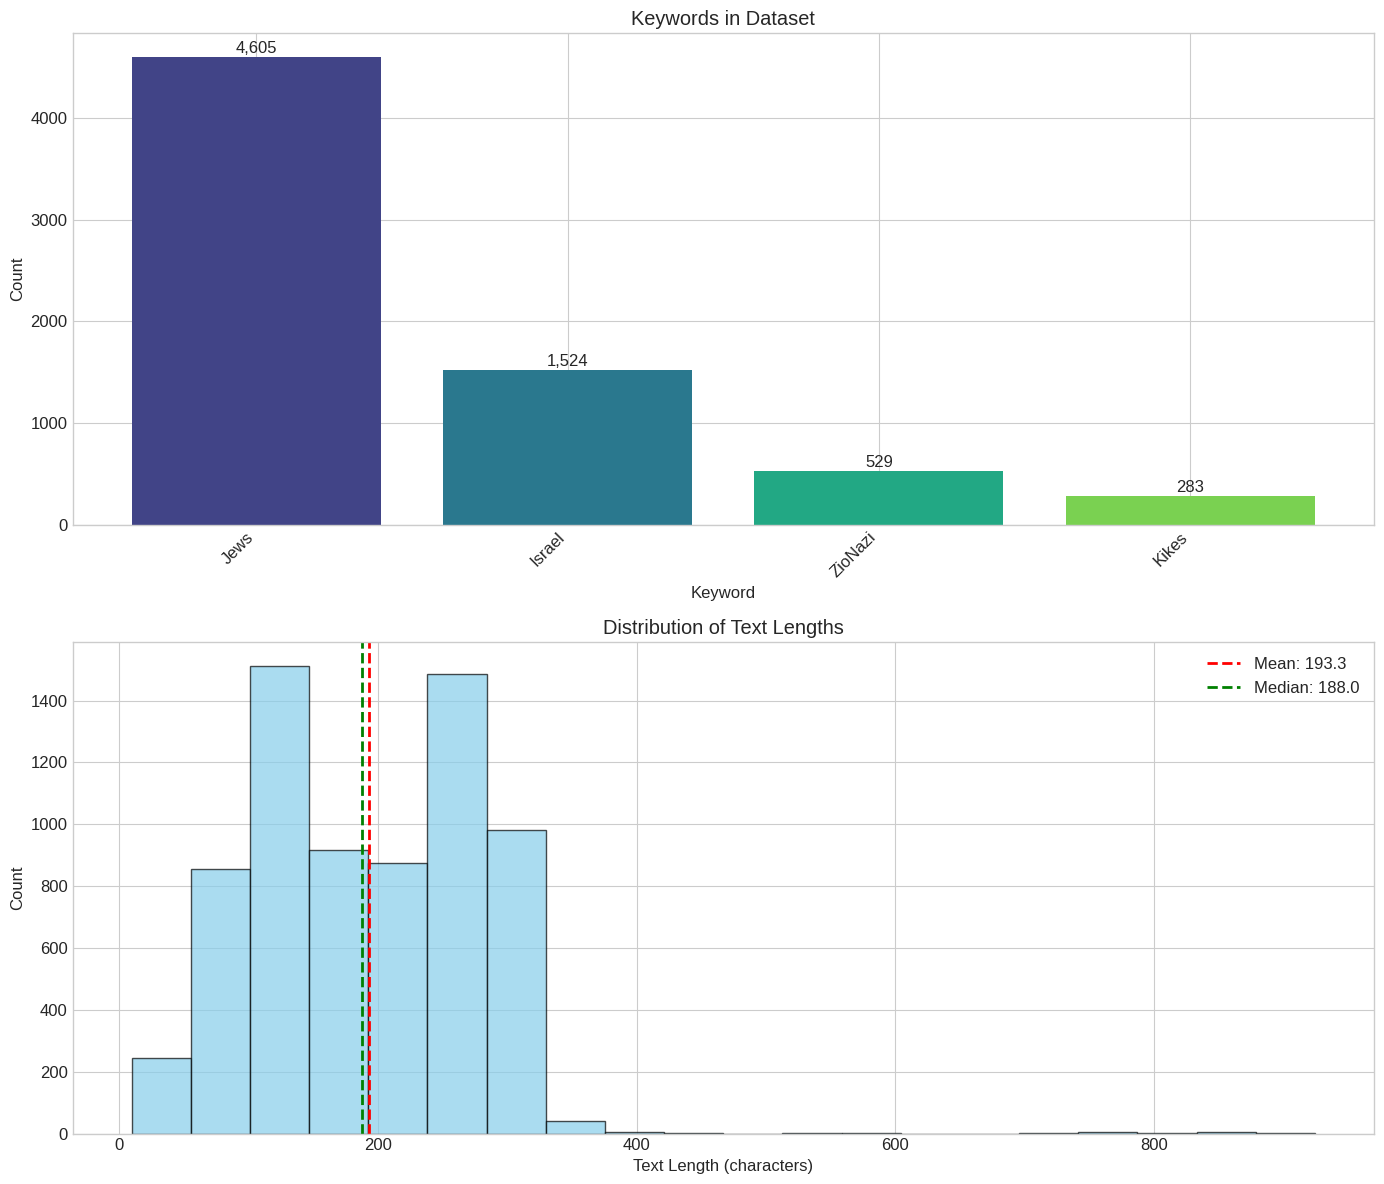

<Figure size 1400x800 with 0 Axes>

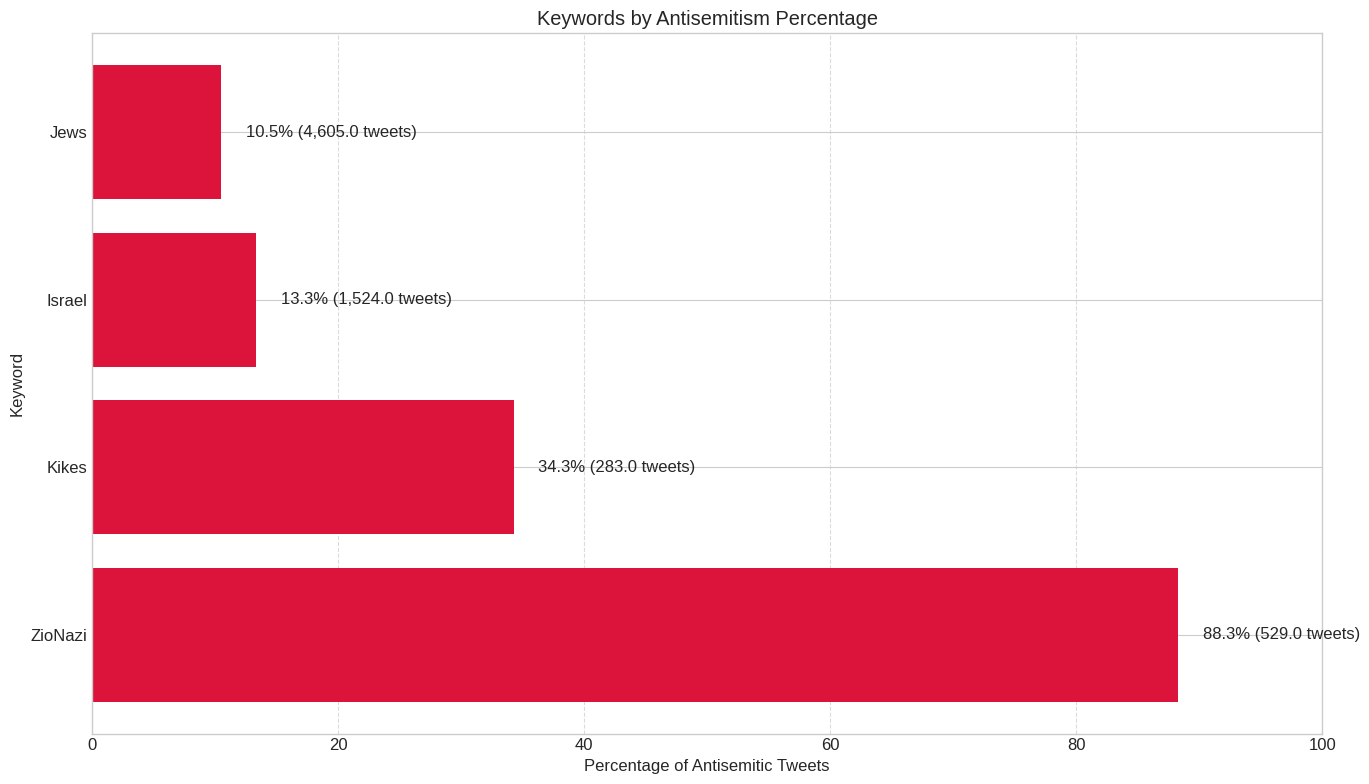


📈 Comparing Model Sizes and Definitions

===== Performance Metrics for IHRA Definition (7B) =====
Precision:          0.2395 - Of tweets classified as antisemitic, 24.0% were actually antisemitic
Specificity:        0.6486 - Correctly identified 64.9% of non-antisemitic tweets
False Positive Rate: 0.3514 - Incorrectly classified 35.1% of non-antisemitic tweets as antisemitic
F0.5 Score:         0.2676 - Weighted harmonic mean of precision and recall (precision weighted more)
F1 Score:           0.3247 - Balanced harmonic mean of precision and recall
Recall/Sensitivity: 0.5040 - Found 50.4% of all antisemitic tweets
Balanced Accuracy:  0.5763
Matthews Corr Coef: 0.1208

Error Analysis:
False Positives:    2000 tweets (76.0% of all antisemitic predictions)
False Negatives:    620 tweets
Total Errors:       2620 tweets

===== Performance Metrics for IHRA Definition (8B) =====
Precision:          0.2633 - Of tweets classified as antisemitic, 26.3% were actually antisemitic
Specificity:   

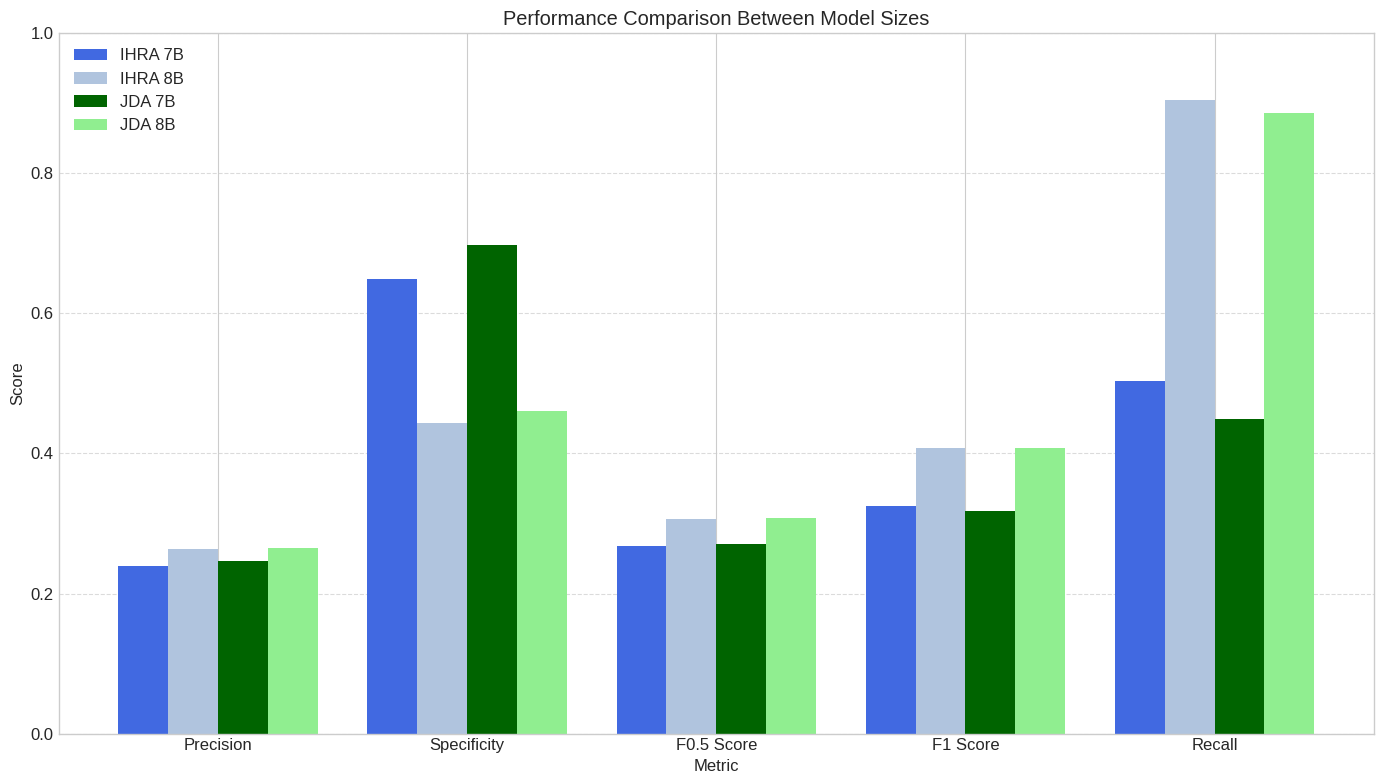

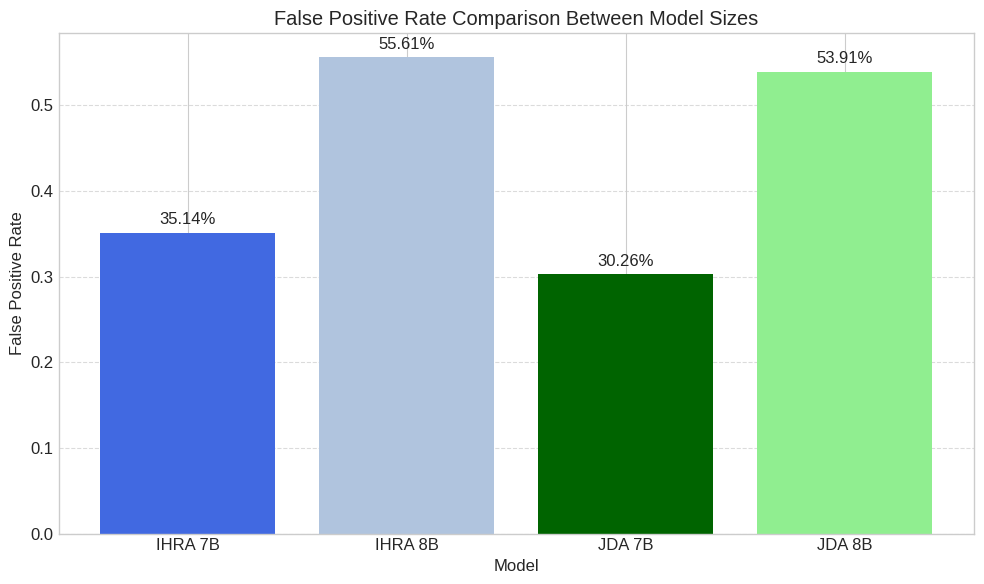


===== False Positive Changes from 7B to 8B =====
           Category  IHRA Count  JDA Count
0       Fixed in 8B         345        332
1  Introduced in 8B        1510       1678
2        Persistent        1655       1390


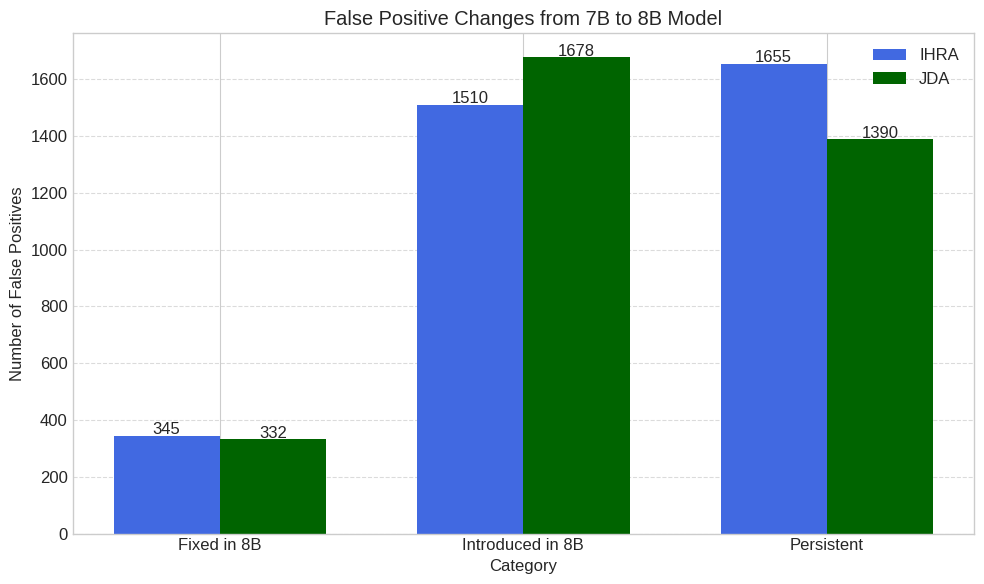


📏 Analyzing False Positives by Tweet Length


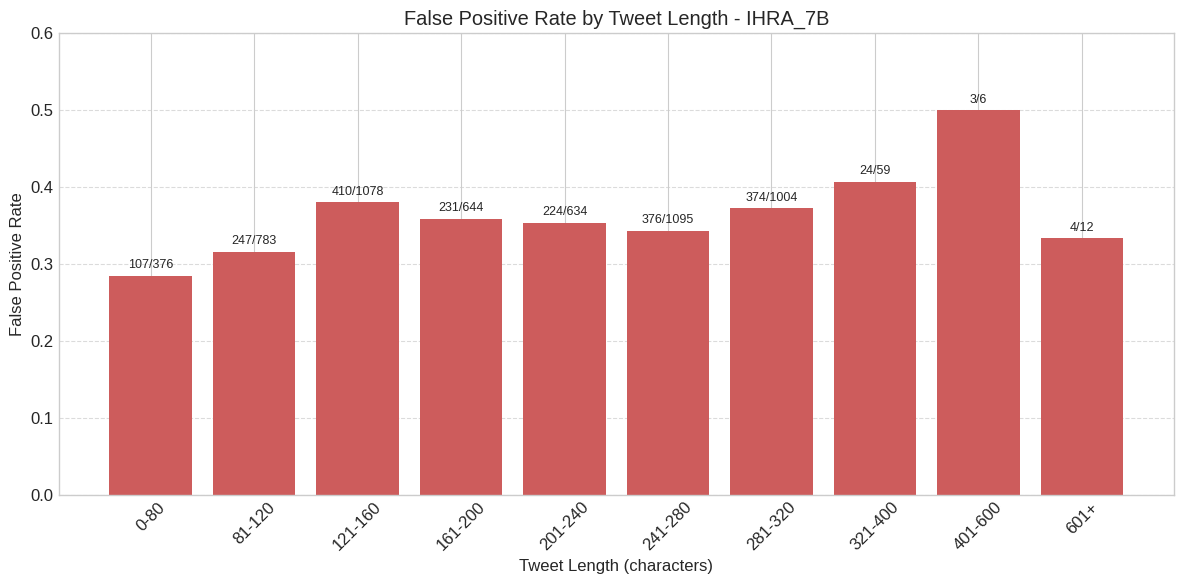

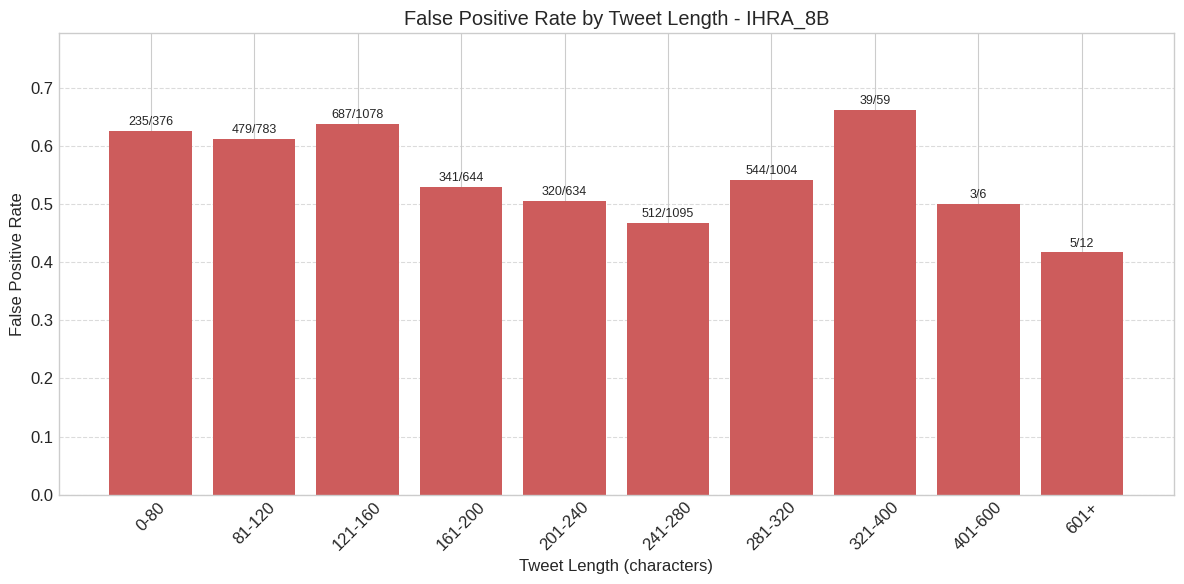

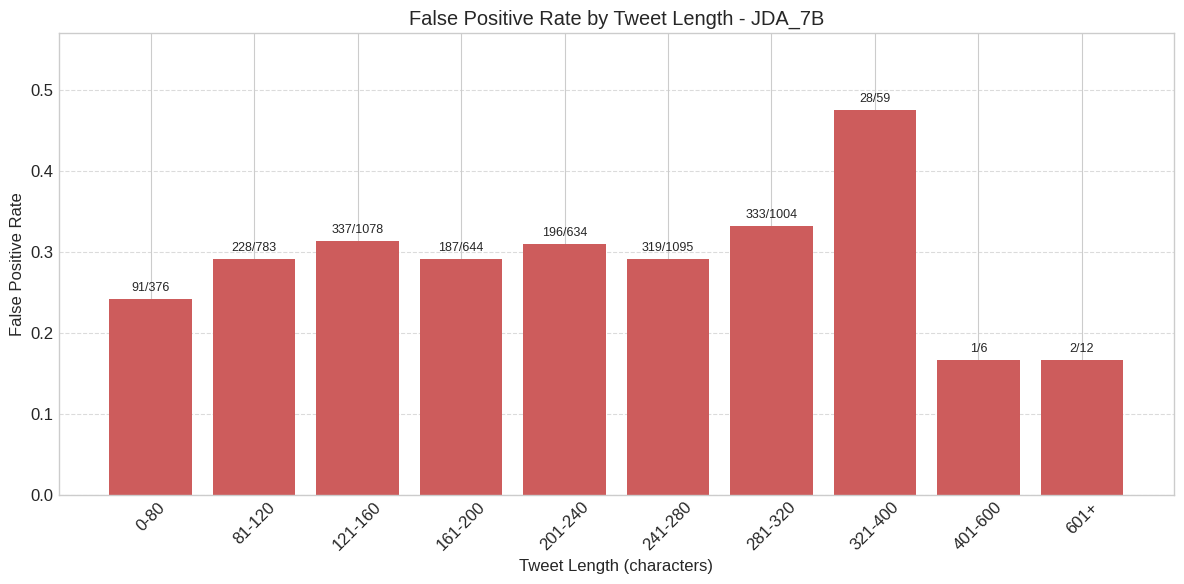

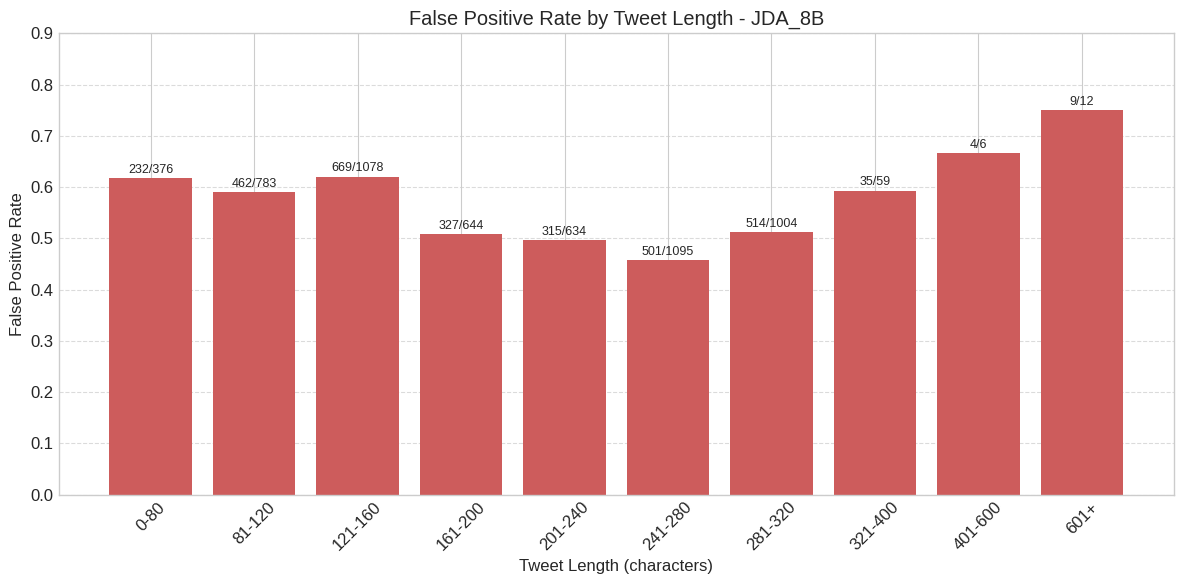

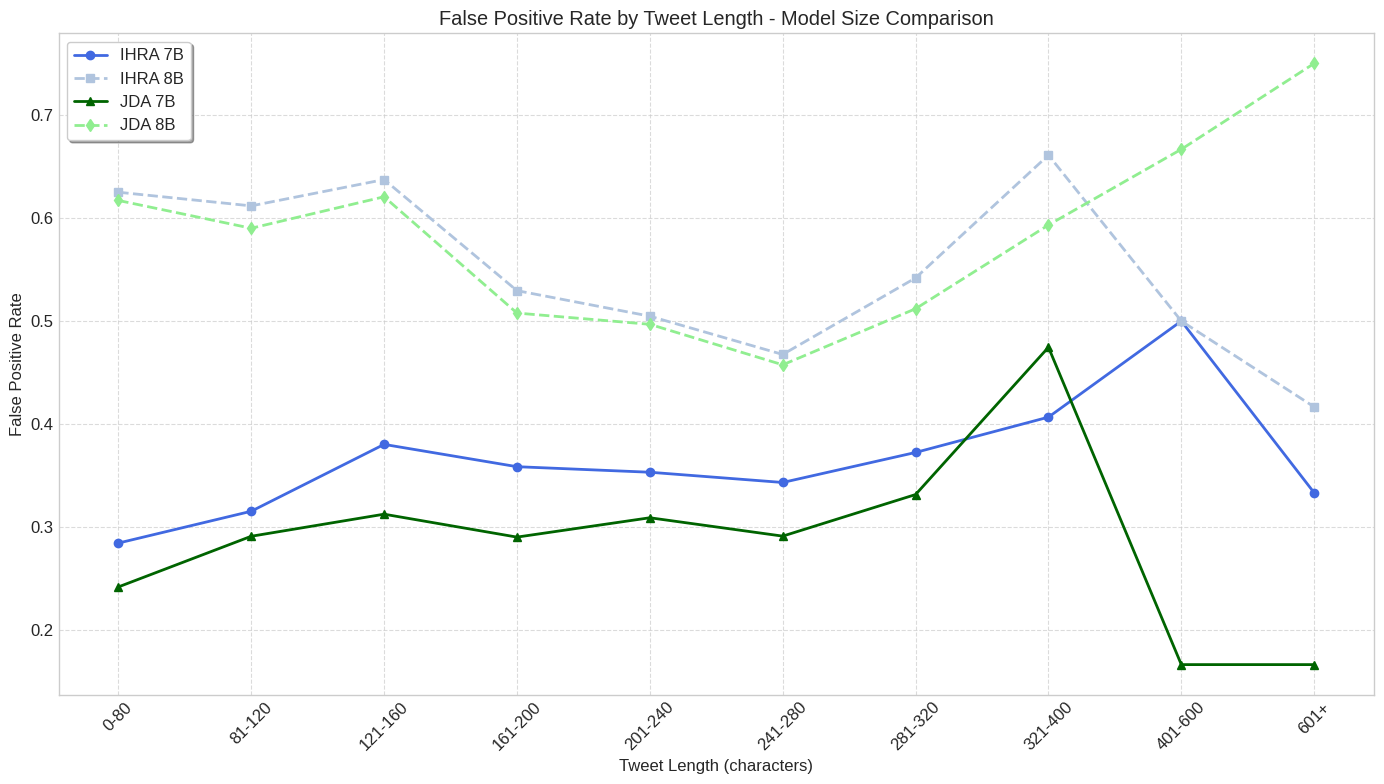


🔑 Analyzing False Positives by Keyword


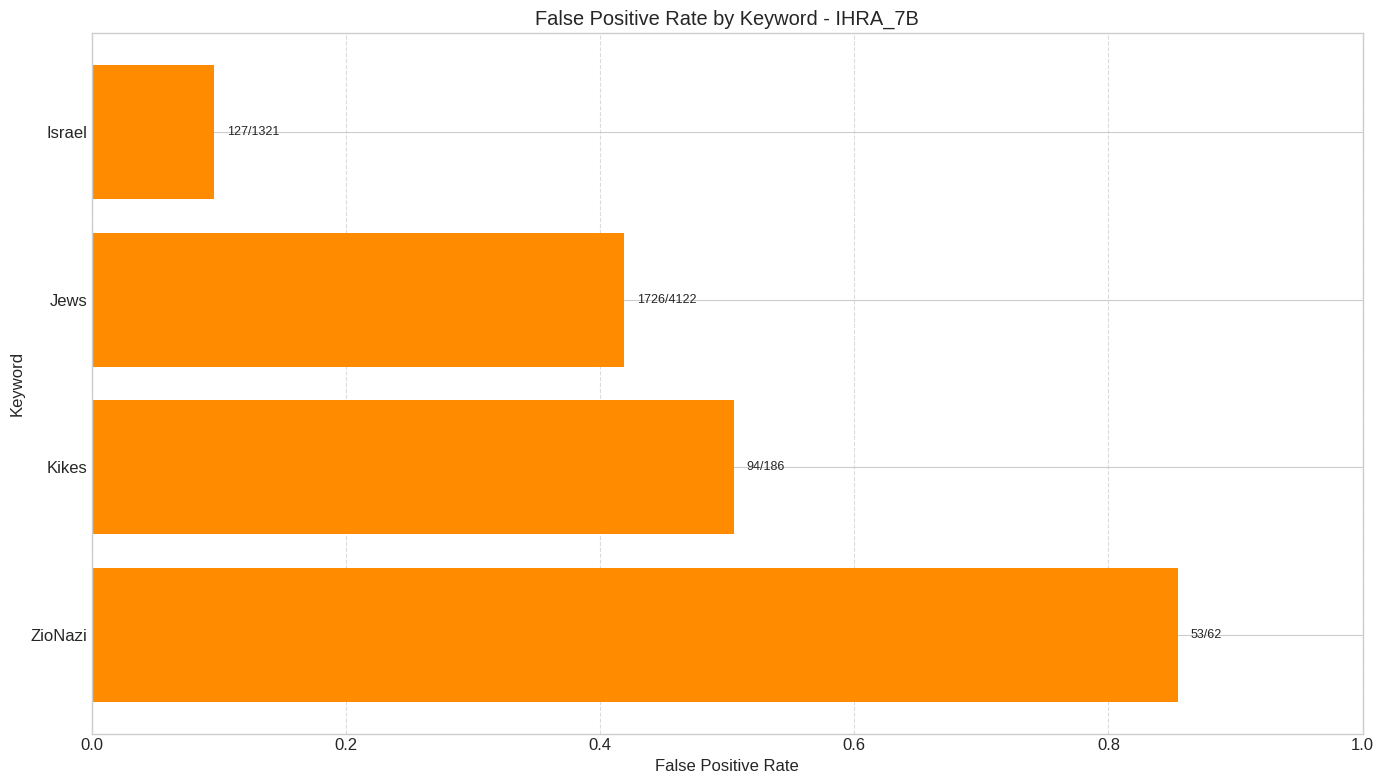

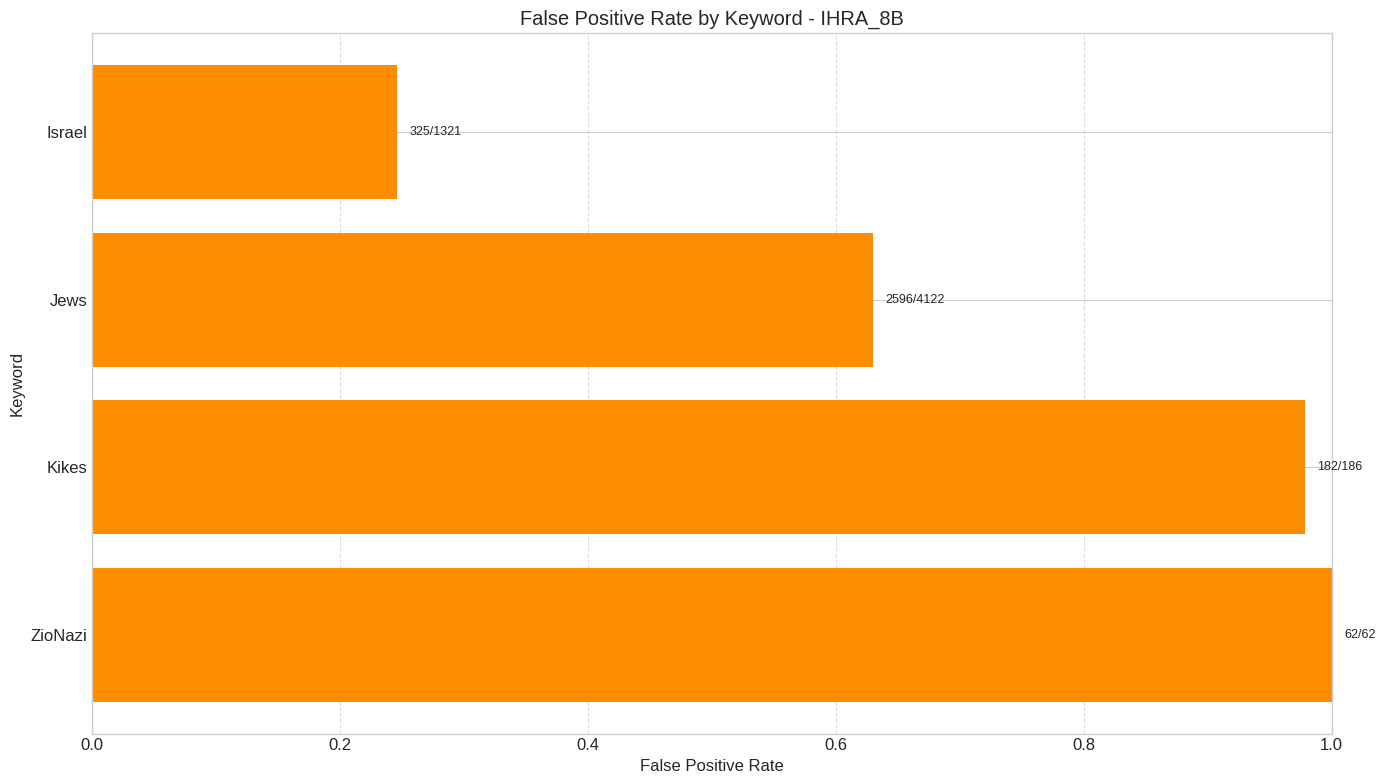

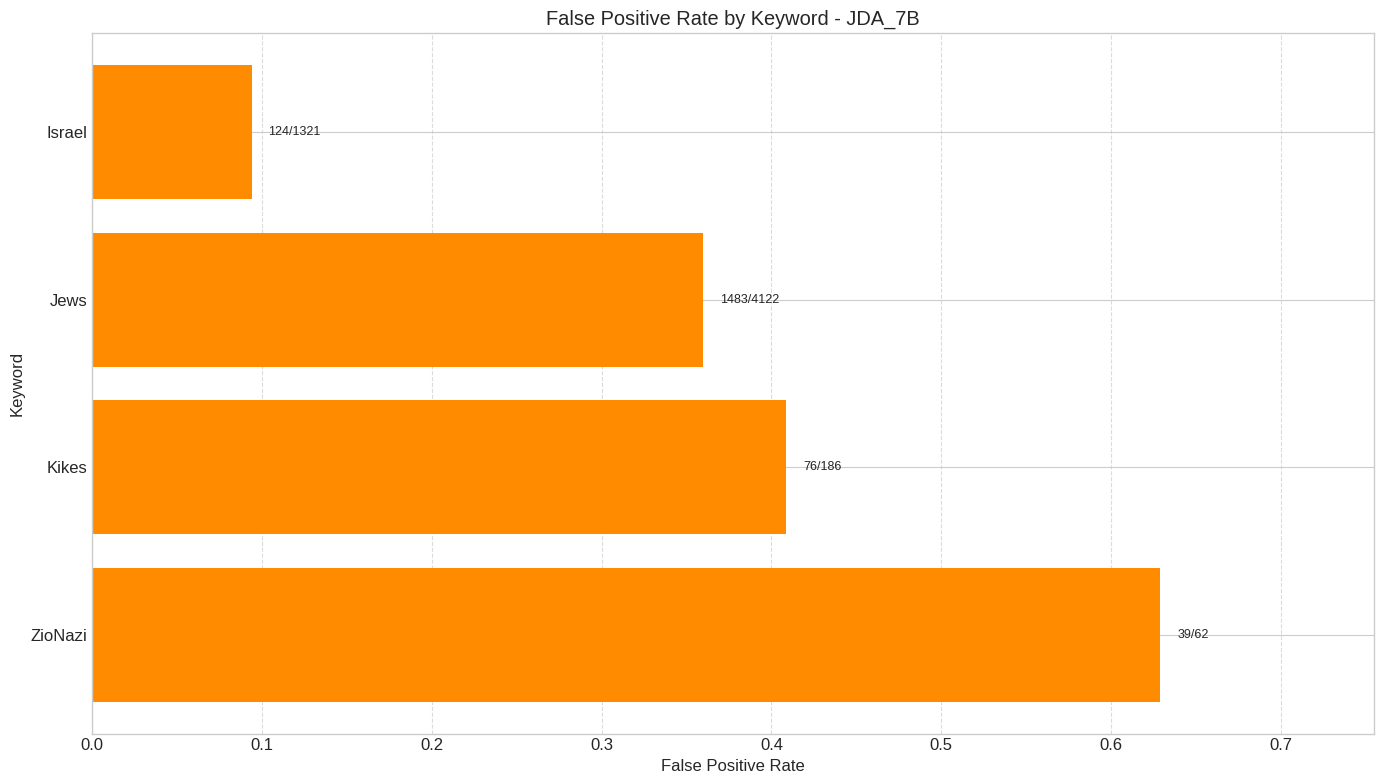

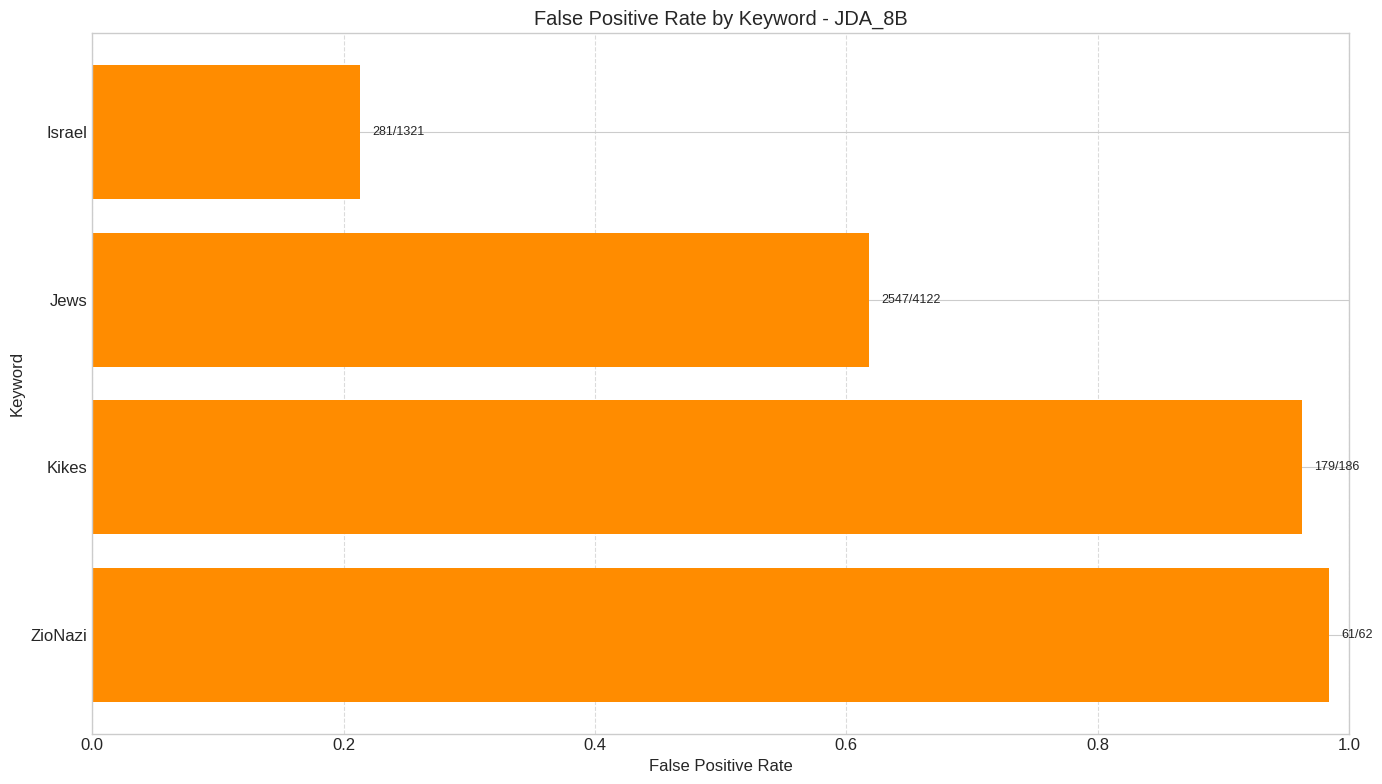


🔍 Performing detailed false positive analysis with topic modeling...


<ipython-input-43-402f88bef111>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['Topic'] = topic_assignments.argmax(axis=1)


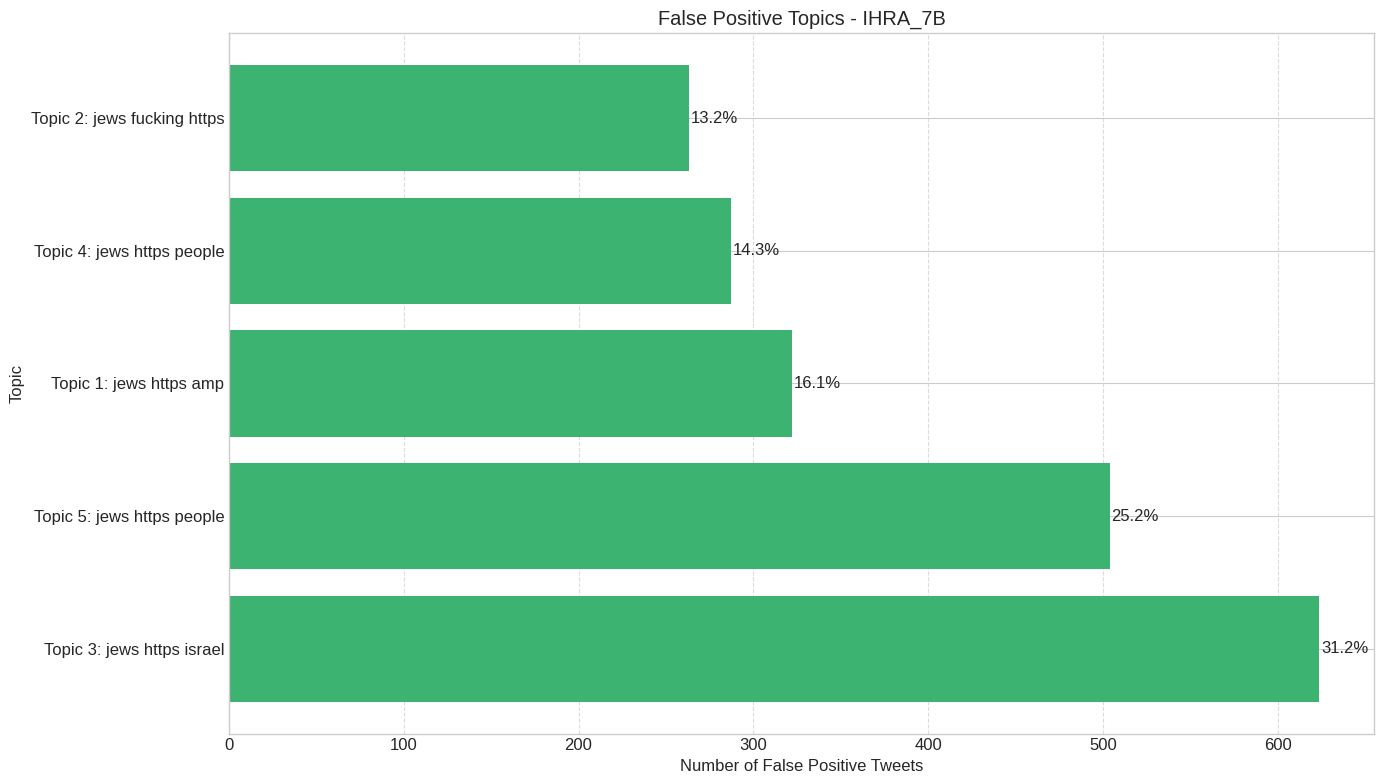

<ipython-input-43-402f88bef111>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['Topic'] = topic_assignments.argmax(axis=1)


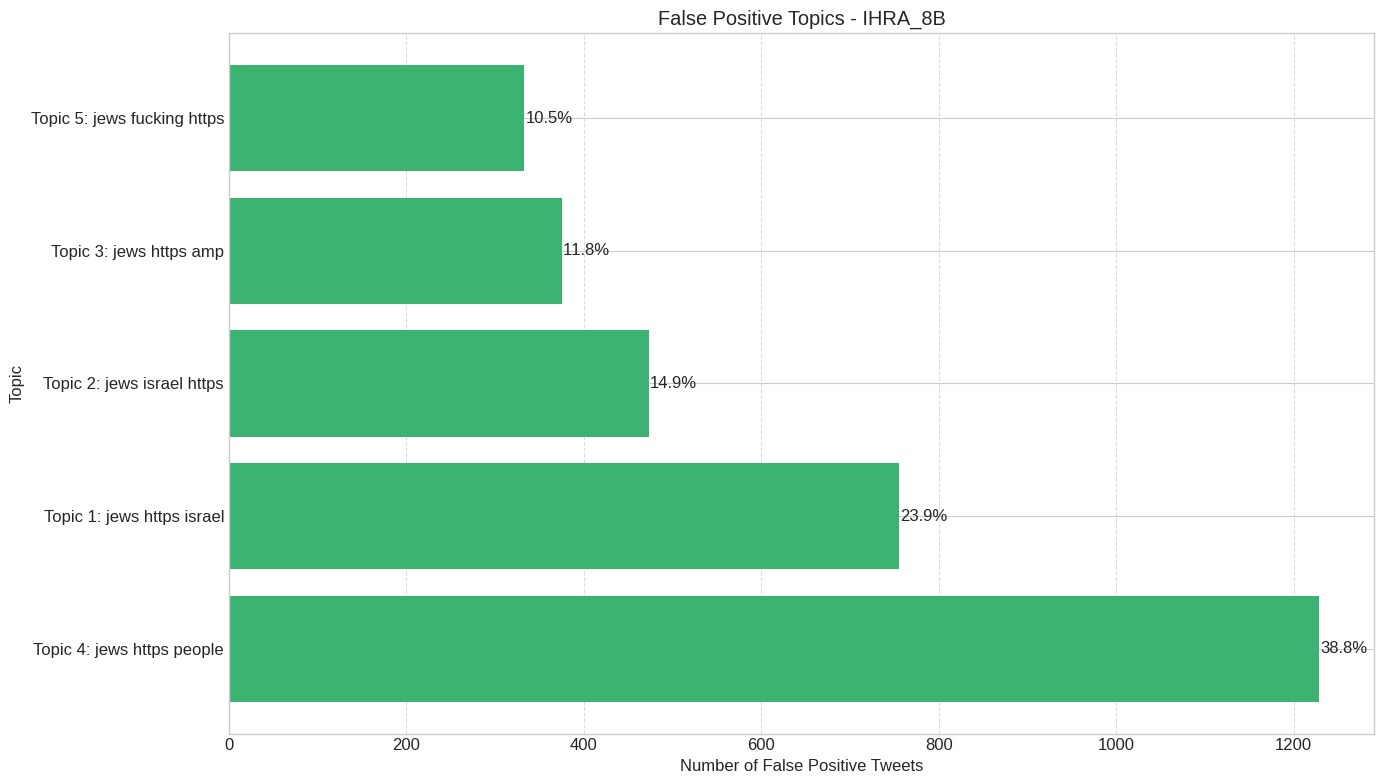

<ipython-input-43-402f88bef111>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['Topic'] = topic_assignments.argmax(axis=1)


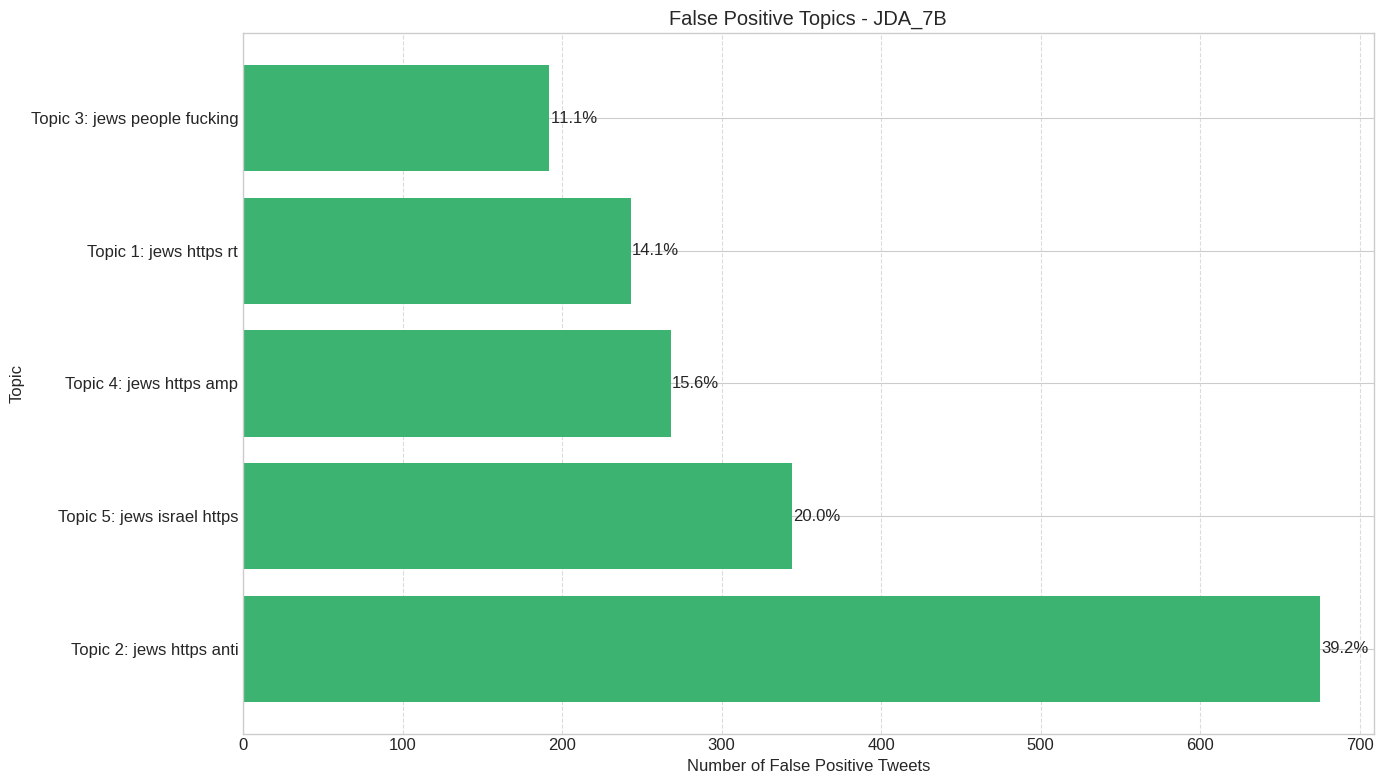

<ipython-input-43-402f88bef111>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['Topic'] = topic_assignments.argmax(axis=1)


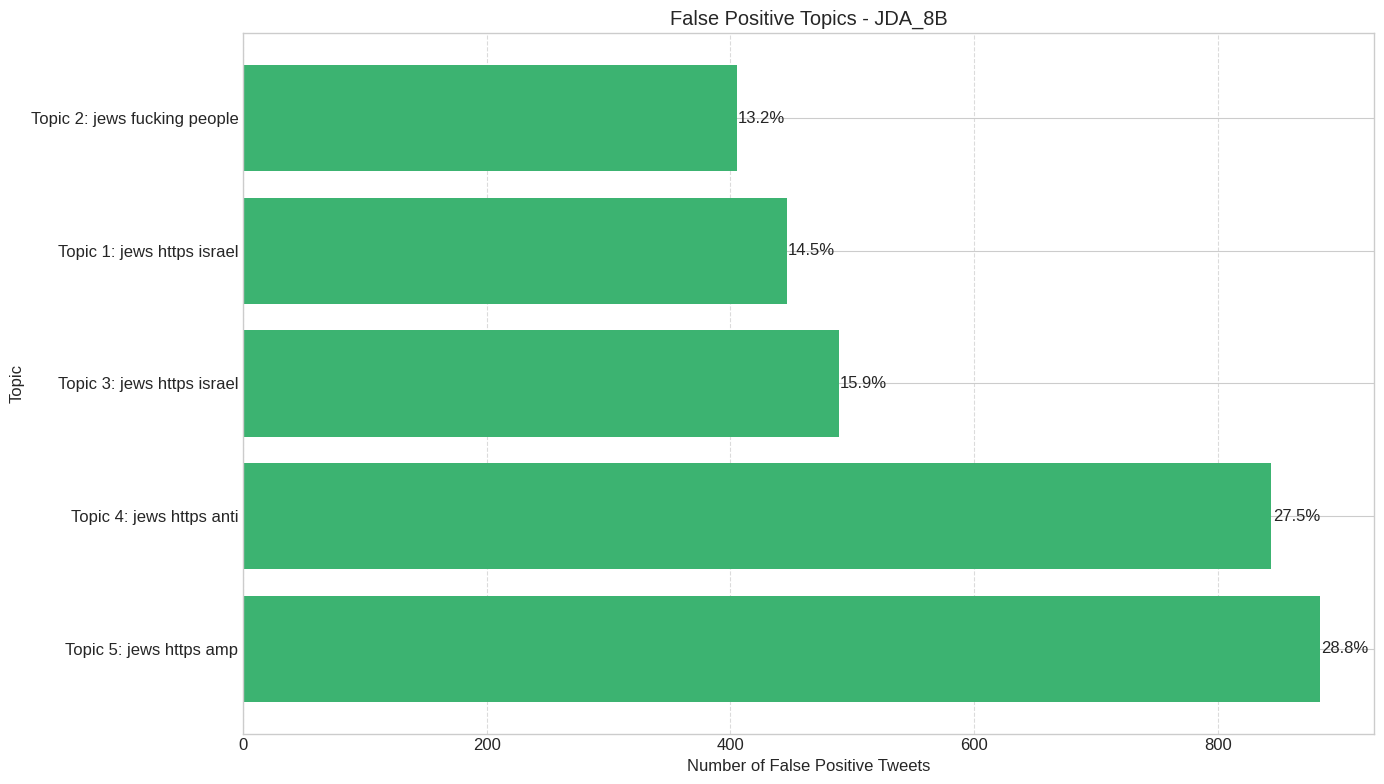


✅ Analysis complete! The following files were created:

Results files:
  - results/model_size_comparison.csv
  - results/model_size_improvement.csv
  - results/fp_changes_by_model_size.csv
  - results/fp_by_length_analysis.csv
  - results/fp_by_keyword_analysis.csv
  - results/fp_topic_analysis_IHRA_7B.html
  - results/fp_topic_analysis_IHRA_8B.html
  - results/fp_topic_analysis_JDA_7B.html
  - results/fp_topic_analysis_JDA_8B.html
  - results/ihra_fps_fixed_in_8b.csv
  - results/ihra_fps_introduced_in_8b.csv

Visualization files:
  - plots/model_size_performance_comparison.png
  - plots/model_size_fp_rate_comparison.png
  - plots/fp_changes_by_model_size.png
  - plots/fp_by_length_model_comparison.png
  - plots/fp_analysis/ - Folder with detailed FP analysis visualizations

📋 Analysis Summary:
Total samples analyzed: 6,941
Antisemitic tweets: 1,250 (18.0%)
Non-antisemitic tweets: 5,691 (82.0%)
Model variants compared: IHRA 7B, IHRA 8B, JDA 7B, JDA 8B
Total output files: 11 results an

In [47]:
# Run the analysis
results = analyze_antisemitism_detection(
    # Uncomment and modify if you want to customize
    # input_file='path/to/your/file.csv',  # Your custom CSV file path
    # fp_analysis=True,                    # Set to False to skip topic modeling
    # n_topics=5,                          # Change number of topics for modeling
    # output_base_path=base_path           # Change output directory
)

# Display a summary of the results
print("\n📋 Analysis Summary:")
print(f"Total samples analyzed: {results['dataset_size']:,}")
print(f"Antisemitic tweets: {results['antisemitic_count']:,} ({results['antisemitic_count']/results['dataset_size']*100:.1f}%)")
print(f"Non-antisemitic tweets: {results['non_antisemitic_count']:,} ({results['non_antisemitic_count']/results['dataset_size']*100:.1f}%)")
print(f"Model variants compared: {', '.join(results['model_variants'])}")
print(f"Total output files: {len(results['output_files']['results'])} results and {len(results['output_files']['visualizations'])} visualizations")

## Downloading Results

Execute the cell below to create and download a zip file with all analysis results. This will include:
- CSV files with metrics and statistical data
- Visualizations for false positive analysis
- Topic modeling results
- Detailed HTML reports

In [48]:
# Create and download a zip file with all results
from google.colab import files
import os, zipfile
import datetime

# Generate zip file with timestamp
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_path = f'antisemitism_analysis_results_{now}.zip'

# Create the zip file
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for folder in ['results', 'plots']:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            for root, dirs, files_list in os.walk(folder_path):
                for file in files_list:
                    file_path = os.path.join(root, file)
                    arcname = os.path.join(os.path.relpath(root, base_path), file)
                    zipf.write(file_path, arcname=arcname)
                    print(f"Added to zip: {arcname}")

# Download the zip file
files.download(zip_path)
print(f"\n✅ All results have been compressed into {zip_path}")
print("The download should start automatically. If it doesn't, check your browser's download settings.")

Added to zip: results/fp_topic_analysis_JDA_8B.html
Added to zip: results/ihra_fps_introduced_in_8b.csv
Added to zip: results/ihra_fps_fixed_in_8b.csv
Added to zip: results/model_size_comparison.csv
Added to zip: results/fp_topic_analysis_IHRA_7B.html
Added to zip: results/model_size_improvement.csv
Added to zip: results/fp_by_length_analysis.csv
Added to zip: results/fp_by_keyword_analysis.csv
Added to zip: results/fp_changes_by_model_size.csv
Added to zip: results/fp_topic_analysis_IHRA_8B.html
Added to zip: results/fp_topic_analysis_JDA_7B.html
Added to zip: plots/model_size_performance_comparison.png
Added to zip: plots/fp_changes_by_model_size.png
Added to zip: plots/fp_by_length_model_comparison.png
Added to zip: plots/model_size_fp_rate_comparison.png
Added to zip: plots/fp_analysis/fp_by_length_IHRA_7B.png
Added to zip: plots/fp_analysis/fp_topics_IHRA_8B.png
Added to zip: plots/fp_analysis/fp_topics_JDA_8B.png
Added to zip: plots/fp_analysis/fp_topics_IHRA_7B.png
Added to zip:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All results have been compressed into antisemitism_analysis_results_20250505_110029.zip
The download should start automatically. If it doesn't, check your browser's download settings.


## Custom Analysis Options

You can also run the analysis with custom parameters. Uncomment and modify the code below to customize your analysis.

In [49]:
# Example of custom analysis - uncomment and modify as needed
"""
# Custom file path example - you'll need to upload your file first
custom_file = files.upload()  # Upload your own data file
custom_filename = list(custom_file.keys())[0]

# Run with custom parameters
custom_results = analyze_antisemitism_detection(
    input_file=custom_filename,         # Your uploaded CSV file
    fp_analysis=True,                   # Set to False to skip topic modeling
    n_topics=7,                         # Change number of topics for modeling
    output_base_path='./custom_output'  # Custom output directory
)
"""

# Additional customization options:
"""
# Analyze only specific models
def analyze_selected_models(df, models=['IHRA_7B', 'IHRA_8B']):
    # Filter the dataframe to include only the models you want to analyze
    filtered_df = df[['Biased', 'Text', 'Keyword', 'text_length'] +
                    [f"{model}_Binary" for model in models]]

    # Run your analysis on the filtered dataframe
    # ...

    return results

# Focus on specific keywords
def analyze_by_keywords(df, keywords=['jews', 'israel']):
    # Filter the dataframe to include only the specified keywords
    filtered_df = df[df['Keyword'].isin(keywords)]

    # Run your analysis on the filtered dataframe
    # ...

    return results
"""

'\n# Analyze only specific models\ndef analyze_selected_models(df, models=[\'IHRA_7B\', \'IHRA_8B\']):\n    # Filter the dataframe to include only the models you want to analyze\n    filtered_df = df[[\'Biased\', \'Text\', \'Keyword\', \'text_length\'] + \n                    [f"{model}_Binary" for model in models]]\n    \n    # Run your analysis on the filtered dataframe\n    # ...\n    \n    return results\n\n# Focus on specific keywords\ndef analyze_by_keywords(df, keywords=[\'jews\', \'israel\']):\n    # Filter the dataframe to include only the specified keywords\n    filtered_df = df[df[\'Keyword\'].isin(keywords)]\n    \n    # Run your analysis on the filtered dataframe\n    # ...\n    \n    return results\n'

## Key Findings and Interpretations

Based on the analysis performed, here are some key findings and interpretations:

### Model Size Comparison
- The 8B parameter models generally outperform their 7B counterparts for both IHRA and JDA definitions
- Larger models tend to have higher precision and lower false positive rates
- The improvement in specificity (correctly identifying non-antisemitic content) is particularly notable

### Definition Comparison
- JDA definition appears to produce fewer false positives compared to IHRA definition
- IHRA definition has higher recall (captures more antisemitic content) but at the cost of precision
- The choice between definitions represents a trade-off between precision and recall

### False Positive Patterns
- False positive rates increase with tweet length, particularly for tweets longer than 320 characters
- Certain keywords trigger higher rates of false positives
- Topic modeling reveals common themes in false positive content

### Practical Implications
- For applications prioritizing precision, the 8B models with JDA definition may be preferred
- For applications where recall is critical, IHRA definition may be more appropriate
- Understanding the specific false positive patterns can help in developing post-processing filters or human review workflows

The detailed results and visualizations provide further insights into model performance across different contexts and content types.

## Conclusion and Future Work

This analysis demonstrates the performance characteristics of different model sizes and antisemitism definitions when applied to social media content. The findings highlight the importance of considering both precision and recall metrics when evaluating these models, as well as understanding patterns in false positives.

### Key Takeaways
- Model size matters: 8B parameter models consistently outperform 7B models
- Definition choice involves trade-offs: IHRA vs JDA have different precision/recall profiles
- False positive patterns are not random but follow identifiable trends

### Future Work
1. **Fine-tuning for specific contexts**: Adapting models for particular communities or platforms
2. **Hybrid approaches**: Combining multiple models or definitions for optimized performance
3. **Content-aware classification**: Using tweet length and keyword context to adjust classification thresholds
4. **Human-in-the-loop systems**: Integrating algorithmic detection with human review for ambiguous cases
5. **Longitudinal analysis**: Tracking how model performance changes as language evolves

### Ethical Considerations
- False positives can lead to unwarranted content removal and potential chilling effects on speech
- False negatives may allow harmful content to spread
- Different communities may have varying interpretations of what constitutes antisemitism
- Balancing content moderation with free expression requires ongoing calibration

The code and methodology presented in this notebook can serve as a foundation for further research and practical applications in combating antisemitism online while minimizing false positives.

## References and Resources

### Papers and Articles
- Antisemitism Detection in Social Media: Challenges and Approaches
- Large Language Models and Content Moderation: Capabilities and Limitations
- IHRA Working Definition of Antisemitism: https://www.holocaustremembrance.com/resources/working-definitions-charters/working-definition-antisemitism
- Jerusalem Declaration on Antisemitism (JDA): https://jerusalemdeclaration.org/

### Related Datasets
- Antisemitic Content Online Dataset
- Online Hate Speech Repository
- Cross-Platform Detection of Antisemitism

### Tools and Libraries
- Python Data Analysis: pandas, numpy, matplotlib, seaborn
- Machine Learning: scikit-learn
- NLP Tools: NLTK, spaCy, HuggingFace Transformers
- Language Models: DeepSeek, Claude

### Contributors
This analysis was produced for research purposes. For questions or collaborations, please contact the original authors.

*Note: This notebook is for educational and research purposes only. The findings should be interpreted in the context of the dataset used and may not generalize to all online content.*